# Modeling All the Fire Data

### This notebook focus on all the data we've collected for all fires reported. The models below are investigatory and NOT our best predictions. Done to see if any model could give a decent prediction over all of our data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ridge_regression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('../../data/processed/master_dataset_allfires.csv')
np.random.seed(42)

In [4]:
df.describe()

,DiscoveryAcres,total_acres,temp_2m,temp_2m_max,humidity,rain,wind_speed_2m,wind_speed_2m_max,wind_speed_10m,wind_speed_10m_max,surface_soil_wetness_5cm_below,surface_soil_wetness_to_bedrock,landcover_class
count,20276.000000,20276.000000,20276.000000,20276.000000,20276.000000,20276.000000,20276.000000,20276.000000,20276.000000,20276.000000,20276.000000,20276.000000,20276.000000
mean,5.770087,332.427169,18.936656,26.893344,5.224731,0.090735,0.695156,2.180344,1.997514,4.072110,-373.422565,-373.353949,330.965476
std,278.267600,6967.385542,35.814040,36.191712,34.693252,34.757608,34.433346,34.516668,34.486971,34.598067,483.537525,483.590553,182.605131
min,0.010000,0.020000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
25%,0.100000,0.200000,15.900000,23.600000,4.090000,0.000000,1.100000,1.910000,2.230000,3.690000,-999.000000,-999.000000,162.000000
50%,0.100000,0.300000,21.300000,29.230000,6.040000,0.010000,1.740000,3.220000,2.890000,4.840000,0.180000,0.360000,304.000000
75%,1.000000,1.250000,25.150000,33.510000,8.360000,0.510000,2.470000,4.520000,3.820000,6.440000,0.340000,0.420000,489.000000
max,33763.000000,413718.000000,39.350000,48.010000,17.520000,136.130000,9.020000,13.510000,12.950000,18.170000,0.910000,0.920000,584.000000


---
######
### Investigating Correlation Between the Features and Target (DailyAcres) 
######
___

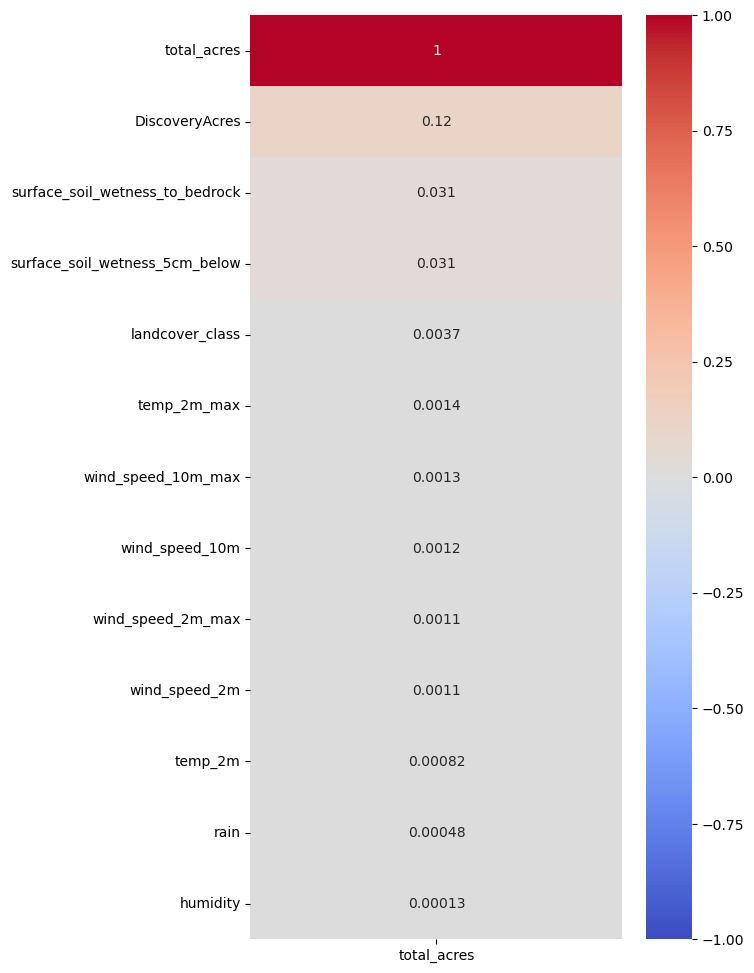

In [34]:
plt.figure(figsize = (6, 12))
sns.heatmap(df[heatmap_cols].corr()[['total_acres']].sort_values(by = 'total_acres', ascending=False),
            vmin = -1,
            vmax = 1, 
            cmap = 'coolwarm',
            annot = True);

---
######
### Feature Selection, Train/Test Splitting Data, and Standard Scaling
######
___

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'total_acres'), df['total_acres'], random_state= 42)

In [36]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

---
######
### Using PCA For Feature Elimination
######
___

In [37]:
pca = PCA(random_state = 42)

Z_train = pca.fit_transform(X_train)
Z_test = pca.transform(X_test)

In [38]:
explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)
np.round(cumulative[:20], 3)

array([0.659, 0.826, 0.91 , 0.992, 0.998, 0.999, 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   ])

In [39]:
Z_train = Z_train[:,:7]
Z_test = Z_test[:,:7]

---
######
### Dummying Landcover_Class and re-train/test splitting
######
___

In [40]:
df = pd.get_dummies(data = df, columns = ['landcover_class'], drop_first= True)
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'total_acres'), df['total_acres'], random_state= 42)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [31]:
#Saving the PCA data for investigations in Neural Nets
#np.savetxt('../../data/processed/Neural_Net_Data/X_train_allfires.csv', X_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/X_test_allfires.csv', X_test, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/Z_train_allfires.csv', Z_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/Z_test_allfires.csv', Z_test, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/y_train.csv', y_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/y_test.csv', y_test, delimiter=',')

---
######
### Modeling / Simple Models
######
---

#### Linear Regression (Baseline) with DF

In [41]:
#Linear Regression - Baseline
# With X data
lr = LinearRegression()

lr.fit(X_train, y_train)
print(f'Training R-Squared: {lr.score(X_train, y_train)}')
print(f'Testing R-Squared: {lr.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(X_test), squared = False)}')

Training R-Squared: 0.025105848724866875
Testing R-Squared: -5.997249191851322e+18
RMSE: 15025204695069.312


#### Linear Regression (Baseline) with PCA

In [42]:
#Linear Regression - Baseline
# With PCA Data
lr = LinearRegression()

lr.fit(Z_train, y_train)
print(f'Training R-Squared: {lr.score(Z_train, y_train)}')
print(f'Testing R-Squared: {lr.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(Z_test), squared = False)}')

Training R-Squared: 0.014319057979142902
Testing R-Squared: 0.01401542634412789
RMSE: 6092.273755954754


In [43]:
def model_eval(model, param_dict, training_data):
    '''
    This function gridsearches a model (arg: model, instantiated before function call) over the given parameters (param_dict) 
    and evalutated on the given training data (either X from DF or Z from PCA'd components)
    '''
    
    gs_model = GridSearchCV(model,
                            param_grid = param_dict,
                            n_jobs = -1)
    if training_data == 'X_train':
        gs_model.fit(X_train, y_train)
        print(f'Best Score: {gs_model.best_score_}')
        print(f'Best Params: {gs_model.best_params_}')
        print('='*50)
        print(f'RMSE: {mean_squared_error(y_test, gs_model.predict(X_test), squared = False)}')
        print('='*50)
        print(f'Training R-Squared: {gs_model.score(X_train, y_train)}')
        print(f'Testing R-Squared: {gs_model.score(X_test, y_test)}')
        
    elif training_data == 'Z_train':
        gs_model.fit(Z_train, y_train)
        print(f'Best Score: {gs_model.best_score_}')
        print(f'Best Params: {gs_model.best_params_}')
        print('='*50)
        print(f'RMSE: {mean_squared_error(y_test, gs_model.predict(Z_test), squared = False)}')
        print('='*50)
        print(f'Training R-Squared: {gs_model.score(Z_train, y_train)}')
        print(f'Testing R-Squared: {gs_model.score(Z_test, y_test)}')
    else:
        return 'Try Again'

#### KNN Regression with DF

In [44]:
#KNN Regressor with X Data
    #Using high n_neighbors trying to combat high variance

knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(1000, 2001, 100),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'X_train')

Best Score: 0.00021933825379818472
Best Params: {'n_neighbors': 1700, 'weights': 'uniform'}
RMSE: 6134.238413704696
Training R-Squared: 0.001383982700420061
Testing R-Squared: 0.00038537254762760487


#### KNN Regression with PCA Data

In [45]:
#KNN Regressor with PCA Data
    #Using high n_neighbors trying to combat high variance

knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(1000, 2001, 100),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'Z_train')

Best Score: 0.000125956597733623
Best Params: {'n_neighbors': 2000, 'weights': 'uniform'}
RMSE: 6133.536279317222
Training R-Squared: 0.001500868697780211
Testing R-Squared: 0.0006141943144444273


#### Lasso Regression with DF

In [46]:
# Lasso Regression with X Data

lasso = Lasso()
lasso_params = {
    'alpha': range(1, 10)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'X_train')

Best Score: -0.00714604637438061
Best Params: {'alpha': 9}
RMSE: 6166.51584267946
Training R-Squared: 0.02484841596594556
Testing R-Squared: -0.010161943905328874


#### Lasso Regression with PCA

In [47]:
# Lasso Regression with PCA Data

lasso = Lasso()
lasso_params = {
    'alpha': range(90, 200, 2)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'Z_train')

Best Score: 0.015348479279944937
Best Params: {'alpha': 90}
RMSE: 6098.286145623219
Training R-Squared: 0.013927120687144079
Testing R-Squared: 0.01206835406950979


#### Adaboost Regression with DF

In [48]:
# Adaboost with X Data

ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(40, 81, 10),
    'learning_rate': np.linspace(0.01, .25, 10) 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'X_train')

Best Score: -0.0007568749559327071
Best Params: {'learning_rate': 0.01, 'n_estimators': 60}
RMSE: 6136.442446489638
Training R-Squared: 0.21796130495081933
Testing R-Squared: -0.0003330798712923855


#### Adaboost Regression with PCA

In [49]:
# Adaboost with PCA Data

ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(10, 101, 10),
    'learning_rate': np.linspace(0.2, .75, 10) 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'Z_train')

Best Score: -0.02166393307434311
Best Params: {'learning_rate': 0.2, 'n_estimators': 10}
RMSE: 6127.712726183758
Training R-Squared: 0.22266578361078193
Testing R-Squared: 0.0025110489689922355


---
######
### Modeling / Ensemble Models
######
---

#### Stacking Regression with DF and with DecisionTreeRegressor Final Estimator

In [50]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=DecisionTreeRegressor(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: -0.9178076714034054
Testing R-Squared: -2.441666239644778
RMSE: 11382.265872904358


#### Stacking Regression with PCA and with DecisionTreeRegressor Final Estimator

In [51]:
# Stacking Regressor with Z_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=DecisionTreeRegressor(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: -0.1904949226045234
Testing R-Squared: 0.0031659860922609306
RMSE: 6125.70071115301


#### Stacking Regression with DF and with LinearRegression Final Estimator

In [52]:
# Stacking Regressor

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: -0.02104737651863786
Testing R-Squared: -0.0020193756088338066
RMSE: 6141.612474196908


#### Stacking Regression with PCA and with LinearRegression Final Estimator

In [53]:
# Stacking Regressor

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.007126796159197757
Testing R-Squared: 0.014875501540960623
RMSE: 6089.616028409128


#### Stacking Regression with PCA and with Lasso Final Estimator

In [54]:
# Stacking Regressor

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.006975590229424289
Testing R-Squared: 0.014927436043311149
RMSE: 6089.455507913107


#### Stacking Regression (different base estimators) with PCA and with LinearRegression Final Estimator

In [55]:
# Stacking Regressor

lvl1_est = ([
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.007165129966354877
Testing R-Squared: 0.014994443475620733
RMSE: 6089.248393365456


#### Voting Regression with PCA

In [56]:
#Voting Regression

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

vote = VotingRegressor(estimators = lvl1_est, n_jobs = -1)

vote.fit(Z_train, y_train)
print(f'Training R-Squared: {vote.score(Z_train, y_train)}')
print(f'Testing R-Squared: {vote.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, vote.predict(Z_test), squared = False)}')

Training R-Squared: -4.323905114991718
Testing R-Squared: -6.864025234632602
RMSE: 17205.480241840625
